In [1]:
import os

In [2]:
folder = 'Данные_Эксперимент_4'

## Исходные данные

In [3]:
import pandas as pd

In [4]:
csv_file_path = r'..\Dataset\Workorder.csv'

data_frame = pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')

In [5]:
num_rows = data_frame.shape[0]
num_rows

107700

In [6]:
data_frame.columns.tolist()

['workorderid',
 'queuename',
 'requesttypedefinition_name',
 'title',
 'description',
 'resolution',
 'servicedefinition_name',
 'categoryname',
 'subcategorydefinition_name']

## html to text

In [7]:
from bs4 import BeautifulSoup

In [8]:
def get_text(html):
    if isinstance(html, float):
        return ''
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text()
    return text

In [9]:
for index, row in data_frame.iterrows():
    
    description = row['description']
    resolution = row['resolution']
    
    text_description = get_text(description)
    text_resolution = get_text(resolution)
    
    data_frame.at[index, 'text_description'] = text_description
    data_frame.at[index, 'text_resolution'] = text_resolution

C:\Users\a.makey\AppData\Local\Temp\ipykernel_21920\3272438639.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, 'html.parser')
C:\Users\a.makey\AppData\Local\Temp\ipykernel_21920\3272438639.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(html, 'html.parser')


## Функции для обработки текста

In [10]:
import re
from collections import defaultdict
import json

In [12]:
with open(os.path.join(folder, 'END_OF_SENT.json'), 'r') as f:
    END_OF_SENT = json.load(f)

# Функция удаления лишнего в конце запроса
def delete_ends(description_list):
    ends_description_list = []
    for i, sentence in enumerate(description_list):
        end_found = False

        for ends in END_OF_SENT:

            if ends in sentence:
                end_found = True
                end_index = sentence.rfind(ends)
                ends_description_list.append(sentence[:end_index])
                break

        if not end_found:
            ends_description_list.append(sentence)
            
    return ends_description_list

In [13]:
def filter_text(text):
    
    filtered_text = text.lower()
    filtered_text = filtered_text.strip()
    
    # Удаление символов '\xa0' и '\n'
    for item in ['\xa0',r'\n']: 
        filtered_text = filtered_text.replace(item, '')
    
    # Удаление всех символов, кроме букв, пробелов и знаков препинания, относящихся к окончанию предложения
    filtered_text = re.sub(r'[^А-Яа-яA-Za-zЁё\s\.\?!]', '', filtered_text)
    # Добавление пробелов слева и справа от знаков препинания, относящихся к окончанию предложения
    filtered_text = re.sub(r'\s*([.?!])\s*', r'\1 ', filtered_text)
    # Замена множественных пробелов на одиночные пробелы
    filtered_text = re.sub(r'\s+', ' ', filtered_text)
    
    return filtered_text, filtered_text.split()

## Признаки
- Группа
- Тип запроса
- Категория услуги
- Категория
- Подкатегория

In [14]:
def sort_key(item):
    key, value = item
    if key == 'nan':
        return float('-inf')
    if key == '[NULL]':
        return float('inf')
    return value

In [15]:
def get_dict_labels(list_labels, exist_null=False):
    dict_labels = defaultdict(int)
    if exist_null:
        dict_labels["[NULL]"] = 0
    for label in list_labels:
        dict_labels[label] += 1
        
    dict_labels = dict(sorted(dict_labels.items(), key=sort_key, reverse=True))
    
    return dict_labels, {class_: index for index, class_ in enumerate(list(dict_labels.keys()))}

In [16]:
# Группа
list_1_labels = [str(row['queuename']) for index, row in data_frame.iterrows()]
dict_1_labels, label_1_to_key = get_dict_labels(list_1_labels)
index_1_labels = [label_1_to_key[label] for label in list_1_labels]
NUM_1_CLASSES = len(label_1_to_key)

In [17]:
# Тип запроса
list_2_labels = [str(row['requesttypedefinition_name']) for index, row in data_frame.iterrows()]
dict_2_labels, label_2_to_key = get_dict_labels(list_2_labels)
index_2_labels = [label_2_to_key[label] for label in list_2_labels]
NUM_2_CLASSES = len(label_2_to_key)

In [18]:
# Категория услуги
list_3_labels = [str(row['servicedefinition_name']) for index, row in data_frame.iterrows()]
dict_3_labels, label_3_to_key = get_dict_labels(list_3_labels, exist_null=True)
index_3_labels = [label_3_to_key[label] for label in list_3_labels]
NUM_3_CLASSES = len(set(index_3_labels))

In [19]:
# Категория
list_4_labels = [str(row['categoryname']) for index, row in data_frame.iterrows()]
dict_4_labels, label_4_to_key = get_dict_labels(list_4_labels, exist_null=True)
index_4_labels = [label_4_to_key[label] for label in list_4_labels]
NUM_4_CLASSES = len(set(index_4_labels))

In [20]:
# Подкатегория
list_5_labels = [str(row['subcategorydefinition_name']) for index, row in data_frame.iterrows()]
dict_5_labels, label_5_to_key = get_dict_labels(list_5_labels, exist_null=True)
index_5_labels = [label_5_to_key[label] for label in list_5_labels]
NUM_5_CLASSES = len(set(index_5_labels))

In [21]:
# Кол- во классов в каждом признаке
NUM_1_CLASSES, NUM_2_CLASSES, NUM_3_CLASSES, NUM_4_CLASSES, NUM_5_CLASSES

(3, 3, 23, 54, 459)

## Анализ признаков
Во втором эксперименте, мы проанализируем распределение классов

In [22]:
import matplotlib.pyplot as plt

In [23]:
def show_classes(dict_labels, label_to_key, save_name=None):
    # Сортировка словаря по значениям в порядке убывания
    my_dict = dict(sorted(dict_labels.items(), key=lambda x: x[1], reverse=True))
    # Получение ключей и значений из словаря
    keys = [i for i in range(len(my_dict.keys()))]
    keys = list(my_dict.keys())
    values = list(my_dict.values())
    
    figure = plt.gcf()
    figure.set_size_inches(15, 5)

    # Построение графика
    plt.bar([i for i in range(len(keys))], values)

    # Добавление подписей значений над столбцами
    for i, v in enumerate(values):
        plt.text(i, v, str(label_to_key[keys[i]]), ha='center', va='bottom')

    # Добавление подписей осей
    plt.xlabel('Классы')
    plt.ylabel('Кол-во запросов')
    
    # Добавление описания графика
    plt.title(save_name)
    
    if save_name:
        # Сохранение графика в виде картинки
        plt.savefig(os.path.join('Диаграммы', f'{save_name}.png'))

    # Отображение графика
    plt.show()

In [24]:
# функция для замены редких классов на 0
def set_rare_classes(dict_labels, limit, label_to_key):
    for key, item in dict_labels.items():
        if (item<limit or key=='nan') and not item == 0:
            label_to_key[key] = 0
    return label_to_key

### Признак 1

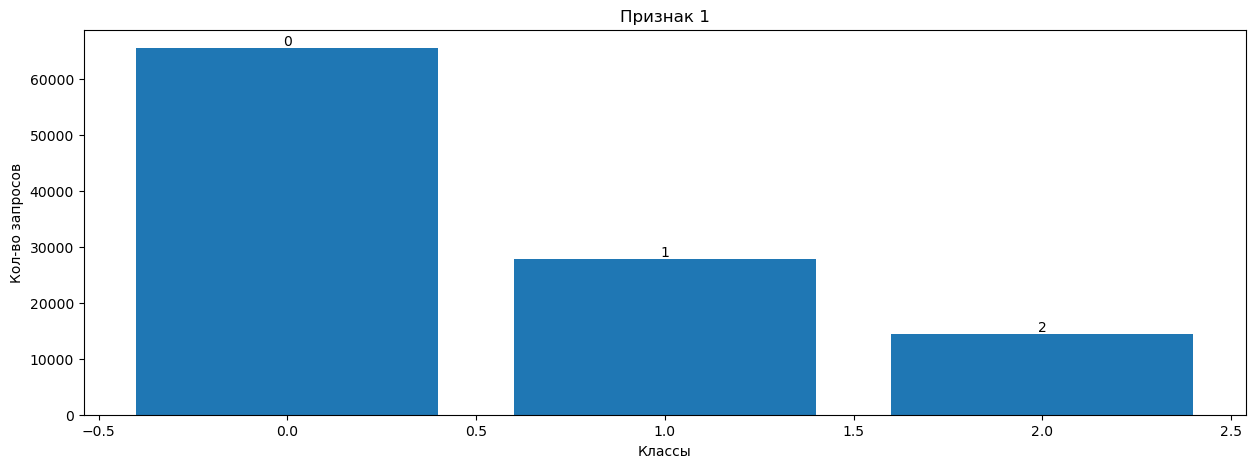

In [25]:
show_classes(dict_1_labels, label_1_to_key, 'Признак 1')

### Признак 2

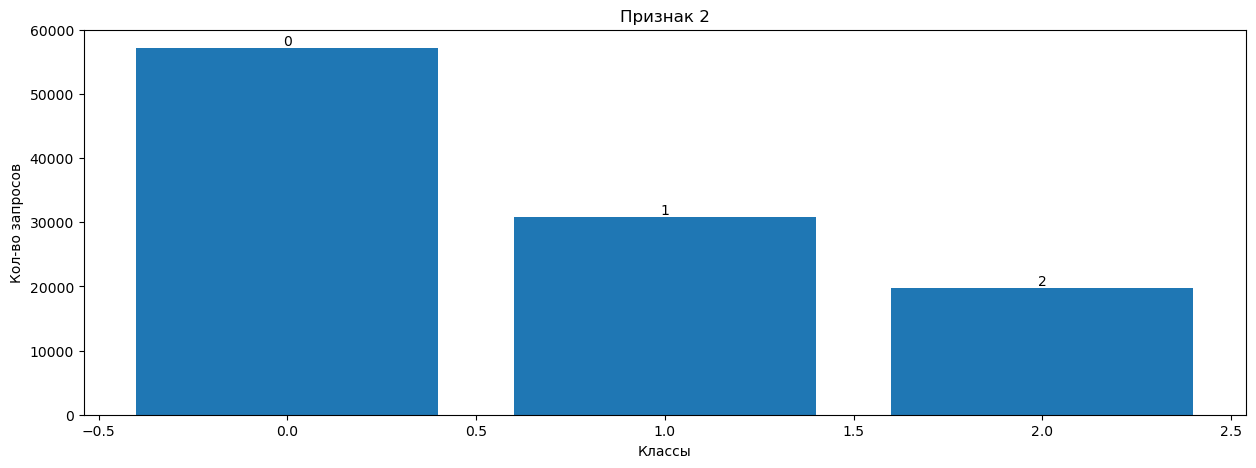

In [26]:
show_classes(dict_2_labels, label_2_to_key, 'Признак 2')

### Признак 3

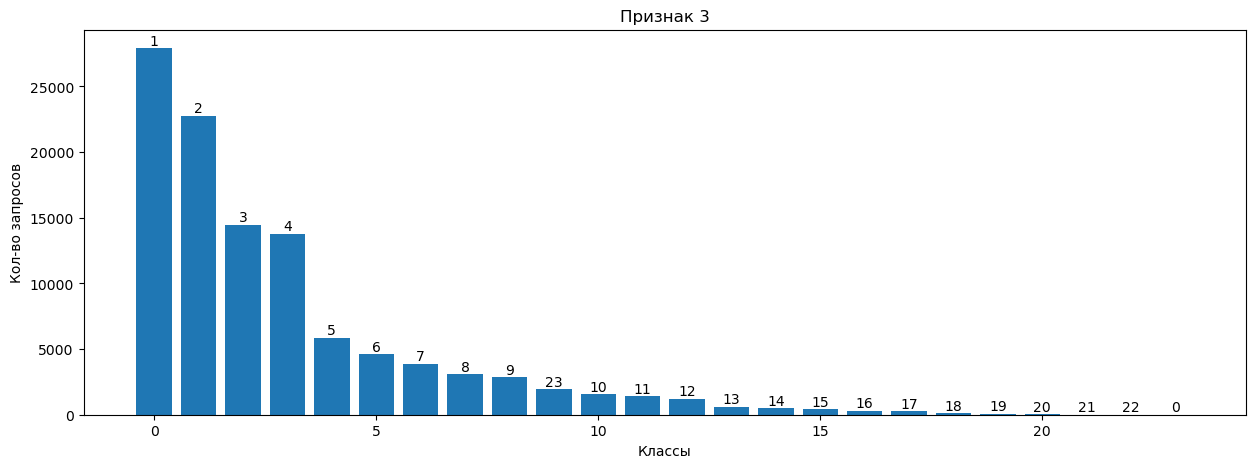

In [27]:
show_classes(dict_3_labels, label_3_to_key, 'Признак 3')

Убираем те классы, которые встречаются менее 1000 раз

In [28]:
label_3_to_key = set_rare_classes(dict_3_labels, 1000, label_3_to_key)

index_3_labels = [label_3_to_key[label] for label in list_3_labels]
NUM_3_CLASSES = len(set(index_3_labels))

### Признак 4

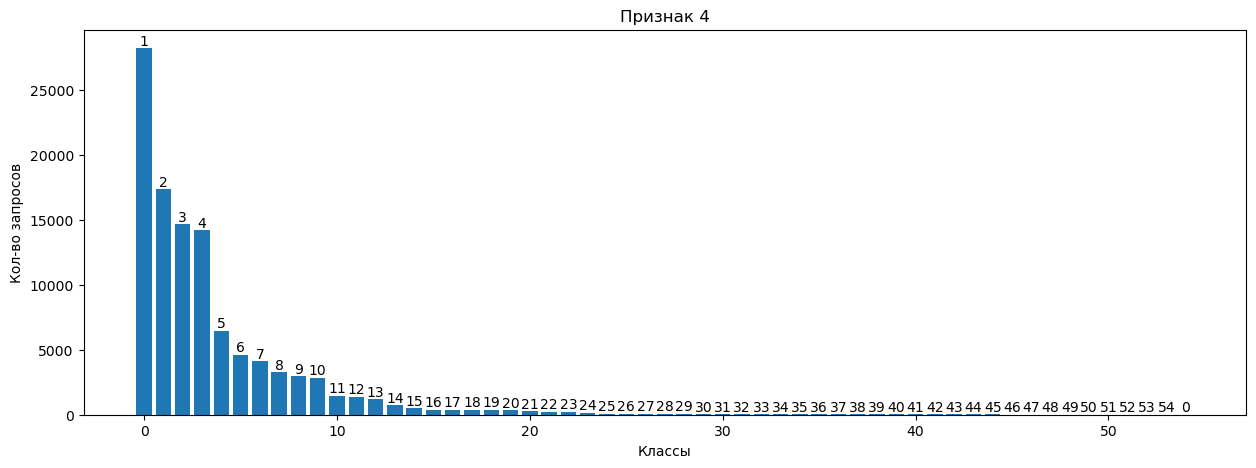

In [29]:
show_classes(dict_4_labels, label_4_to_key, 'Признак 4')

In [30]:
label_4_to_key = set_rare_classes(dict_4_labels, 200, label_4_to_key)

index_4_labels = [label_4_to_key[label] for label in list_4_labels]
NUM_4_CLASSES = len(set(index_4_labels))

### Признак 5

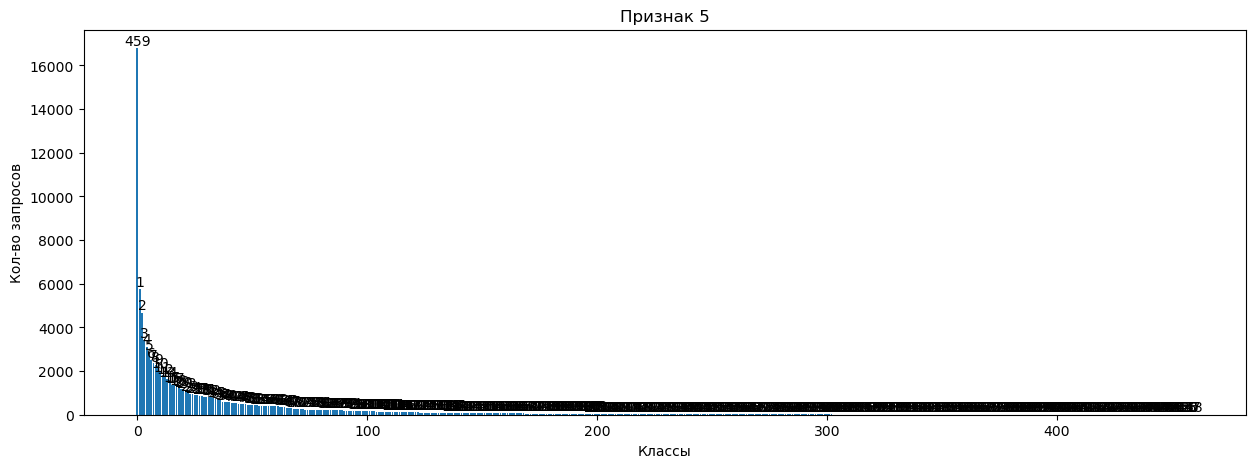

In [31]:
show_classes(dict_5_labels, label_5_to_key, 'Признак 5')

In [32]:
label_5_to_key = set_rare_classes(dict_5_labels, 20, label_5_to_key)

index_5_labels = [label_5_to_key[label] for label in list_5_labels]
NUM_5_CLASSES = len(set(index_5_labels))

In [33]:
# Обновленное кол- во классов в каждом признаке
NUM_1_CLASSES, NUM_2_CLASSES, NUM_3_CLASSES, NUM_4_CLASSES, NUM_5_CLASSES

(3, 3, 13, 24, 257)

Как видим уменьшили кол-во классов в признаках 3, 4, 5 примерно в 2 раза

## Запрос или входная строка

In [35]:
description_list = [str(row['title']) + '. ' + str(row['text_description']) for index, row in data_frame.iterrows()]

description_list = delete_ends(description_list)

description_text = [filter_text(text)[0] for text in description_list]

## Решение или выходная строка

In [37]:
resolution_list = [str(row['text_resolution']) for index, row in data_frame.iterrows()]

resolution_text = [filter_text(text)[0] for text in resolution_list]

## Сохранение данных

In [38]:
import json

# Входные данные
with open(os.path.join(folder, 'description_text.json'), 'w') as f:
    json.dump(description_text, f, indent=4)

# Выходные данные
with open(os.path.join(folder, 'resolution_text.json'), 'w') as f:
    json.dump(resolution_text, f, indent=4)
    
## Признаки и соответствующие словари
with open(os.path.join(folder, 'index_1_labels.json'), 'w') as f:
    json.dump(index_1_labels, f, indent=4)
with open(os.path.join(folder, 'label_1_to_key.json'), 'w') as f:
    json.dump(label_1_to_key, f, indent=4)

with open(os.path.join(folder, 'index_2_labels.json'), 'w') as f:
    json.dump(index_2_labels, f, indent=4)
with open(os.path.join(folder, 'label_2_to_key.json'), 'w') as f:
    json.dump(label_2_to_key, f, indent=4)

with open(os.path.join(folder, 'index_3_labels.json'), 'w') as f:
    json.dump(index_3_labels, f, indent=4)
with open(os.path.join(folder, 'label_3_to_key.json'), 'w') as f:
    json.dump(label_3_to_key, f, indent=4) 

with open(os.path.join(folder, 'index_4_labels.json'), 'w') as f:
    json.dump(index_4_labels, f, indent=4)
with open(os.path.join(folder, 'label_4_to_key.json'), 'w') as f:
    json.dump(label_4_to_key, f, indent=4) 

with open(os.path.join(folder, 'index_5_labels.json'), 'w') as f:
    json.dump(index_5_labels, f, indent=4)
with open(os.path.join(folder, 'label_5_to_key.json'), 'w') as f:
    json.dump(label_5_to_key, f, indent=4) 